In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

# Graphic libraries

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, grid=False)



from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
import stan_utility

#import arviz as az
red = '#D62828'
orange = '#F77F00'
yellow = '#FCBF49'
dark = '#003049'
dark_highlight= '#002437'
light = '#EAE2B7'
light_highlight='#C2BDA2'



# A toy model

We start with a very simple population model:

$$\frac{dN}{dz d\phi} = \Phi(\phi; \psi) n(z;\psi) \frac{dV}{dz} $$

where $\Phi(\phi; \psi)$ is a normalized function of $\phi$ (such as luminosity) give parameters $\psi$ and $n(z;\psi)$ is a rate denisty though we are ignoring time for the moment. I leave all hyper-parameters as members of $\psi$ for simplicty. $\frac{dV}{dz}$ is simply the volume jacobian. 

For simplicty, we can model $\Phi$ as a Pareto distribution:

$$ \Phi(L; \alpha, L_{\mathrm{min}}) = \frac{\alpha L_{\mathrm{min}}^{\alpha}}{L^{\alpha+1}}$$

the rate density as 

$$ n(z;r,d,p) = \frac{1+r\cdot z }{1+(z/p)^{d}}$$

and consider that volume goes as 

$$V(z) = \frac{4}{3} \pi (z+1)^3 \implies \frac{dV}{dz} = 4 \pi (z+1)^2$$ .'


The $(z+1)$ is just to keep strange things from happening when $z<1$ which will be eliminated when we use proper cosmological volumes. With this definition we can related flux to luminosity via:

$$F(L;z) = \frac{L}{4 \pi (z+1)^2 }$$


It would probably be better to keep the likelihood touching the flux as it is the measured value, but I'm not sure that this has any direct consequnce at the moment. Thus, we sample the luminosity from a lognormal distribution and assume homoskedastic error.


In [2]:
# the luminosty function

def phi(L,alpha, L_min):
     return alpha*L_min**alpha / L**(alpha+1)
    

In [3]:

# volume rate
def dNdV(z, r0, rise, decay , peak):
    top = 1 + rise * z
    bottom = 1+np.power(z/peak,decay)
    
    return r0 * top/bottom

# the change in volume with respect to distance
def dVdz(z):
    
    return 4*np.pi * (z+1)**2

# the number of objects per unit distance
def dNdz(z, r0, rise, decay , peak):
    
    return dNdV(z, r0, rise, decay , peak) * dVdz(z)

In [4]:

# rejection sampling from dN/dZ. 
# should it be sampled from dN/dV ??
def draw_zs(r0, rise, decay , peak, zmax, size):
    zs = np.linspace(0, zmax, 10000)
    dndzs = dNdz(zs,r0, rise, decay , peak)
    ymax = np.max(dndzs)
    
    zout = []
    for i in range(size):
        flag = True
        while flag:
            y = np.random.uniform(low=0, high=ymax)
            z = np.random.uniform(low=0, high=zmax)
            if y < dNdz(z, r0, rise, decay , peak):
                zout.append(z)
                flag = False
                  
    return np.array(zout)

In [5]:
# modified pareto to allow for changing Lmin
def draw_luminosity(alpha, L_min, size=1):
    
    return  (np.random.pareto(alpha, size) + 1) * L_min

In [42]:
# sampling statement... the likelihood
def draw_lobs(L, sigma_L, size=1):
    return np.exp(np.log(L) + sigma_L*np.random.randn(size))

# The sampler

In [7]:
def draw_survey(alpha, L_min, r0, rise, decay , peak ,Fth, zmax,sigma_L):
    
    # integrate over redshift to get the full number of objects
    N = integrate.quad(dNdz,0.,zmax,args=( r0, rise, decay , peak))[0]
    
    # this should be poisson distributed
    n = np.random.poisson(N)

    # with out sample size, we can pull luminosities
    # and redshifts
    Ls = draw_luminosity(alpha=alpha, L_min=L_min, size=n)
    zs = draw_zs( r0, rise, decay , peak ,zmax=zmax, size=n)
    
    # give the luminosity some noise
    Lobs = draw_lobs(Ls, sigma_L,size=n)
    
    # compute the "observed flux"
    # the 1+z jsut keeps things from getting weird 
    Fobs = Lobs / (4*np.pi* (zs+1)*(zs+1))
    
    # apply a selection on the flux
    sel = Fobs > Fth
   
    # throw all of this into a dictionary to keep from 
    # screwing up later and inputting incorrect data into Stan
    n_model = 500
    return dict(L_obs = Lobs[sel],
                z_obs = zs[sel] ,
                Nnobs = sel.shape[0]-sum(sel),
                z= zs,
                Fobs = Fobs,
                sigma_L = sigma_L,
                N=len( Lobs[sel]),
                z_max = zmax,
                boundary = Fth,
                L = Ls,
                Lmodel=np.logspace(np.log10(L_min),3,n_model),
                zmodel=np.linspace(0,zmax,n_model),
                N_model=n_model   
               )
                
                

## True values

In [51]:
r0_true = 5E-1
rise_true = 1
decay_true = 3.
peak_true = 2.
alpha_true = 1.
Lmin_true = 10.
zmax = 10.
sigma_L= .1
Fth = 1./(4* np.pi )

In [52]:
np.random.seed(123)

data = draw_survey(alpha_true, Lmin_true, r0_true, rise_true, decay_true, peak_true,Fth, zmax, sigma_L)

print('We observed %d objects and missed %d objects'%(data['N'],data['Nnobs']))


We observed 312 objects and missed 421 objects


<IPython.core.display.Javascript object>


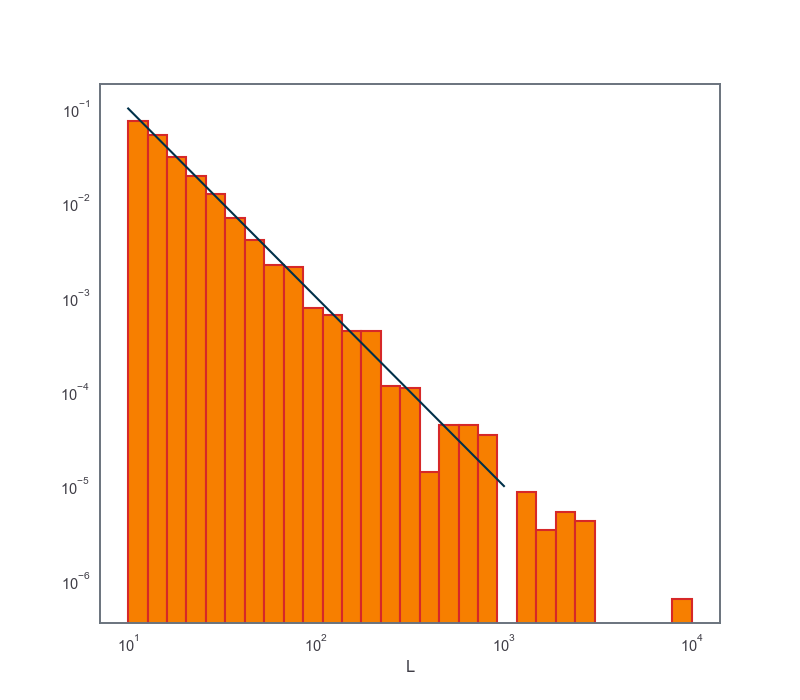

Text(0.5,0,'L')

In [53]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(Lmin_true),4,30)
#ax.hist(data['L_obs'],bins=bins,normed=True)
ax.hist(data['L'],bins=bins,normed=True,facecolor=orange,edgecolor=red,lw=1.5)


ax.plot(data['Lmodel'], phi(data['Lmodel'],alpha=alpha_true,L_min=Lmin_true), color=dark)
#ax.hist(data['L_obs'],bins=bins,normed=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('L')



<IPython.core.display.Javascript object>


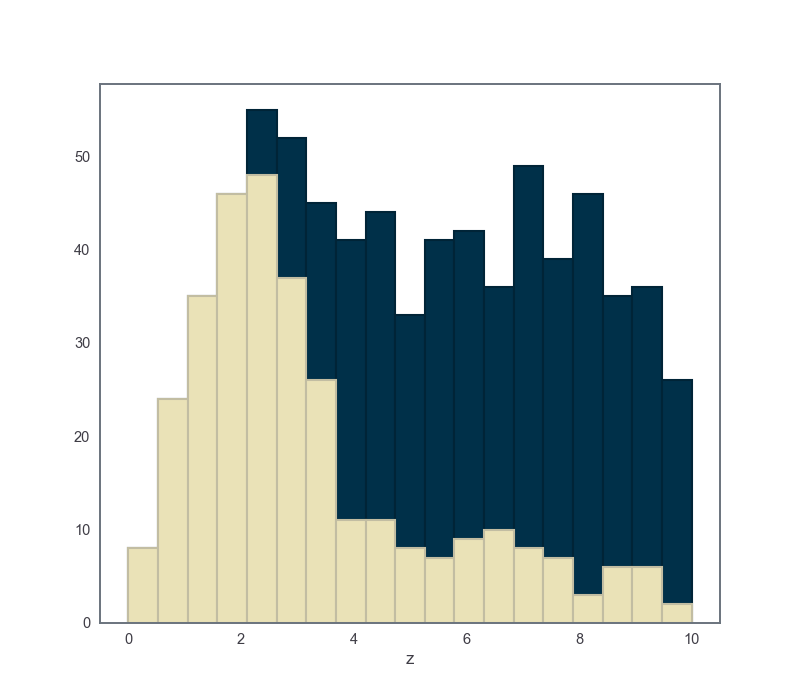

Text(0.5,0,'z')

In [54]:
fig, ax = plt.subplots()
bins = np.linspace(0,zmax,20)
plt.hist(data['z'],bins=bins, facecolor=dark, edgecolor=dark_highlight, lw=1.5)
plt.hist(data['z_obs'],bins=bins, facecolor=light, edgecolor=light_highlight, lw=1.5,alpha=1);

ax.set_xlabel('z')

<IPython.core.display.Javascript object>


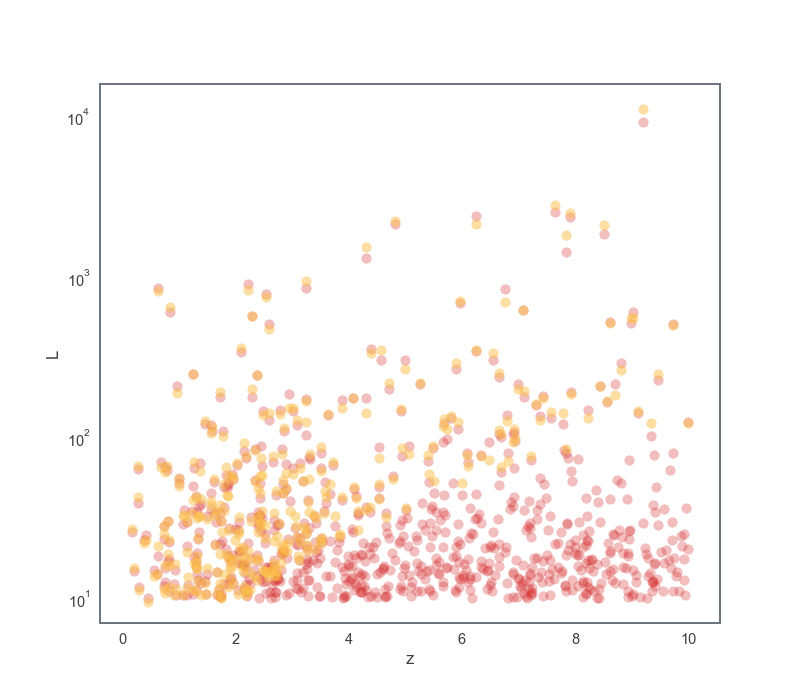

Text(0,0.5,'L')

In [55]:
fig, ax = plt.subplots()

ax.scatter(data['z'],data['L'],alpha=.3,color=red)
ax.scatter(data['z_obs'],data['L_obs'],alpha=.5,color=yellow)

ax.set_yscale('log')
ax.set_xlabel('z')
ax.set_ylabel('L')

In [56]:
model = stan_utility.compile_model('powerlaw_model.stan')

Using cached StanModel


In [58]:
N_margin = 500
data['N_margin'] = N_margin

# for now I am setting these until I know I can fit 
# for the other parmaeters
data['rise'] = rise_true
data['decay'] = decay_true
data['peak'] = peak_true

In [59]:
n_chain = 4

fit = model.sampling(data=data,iter=8000,chains=n_chain,n_jobs=n_chain ,thin=2)


<IPython.core.display.Javascript object>


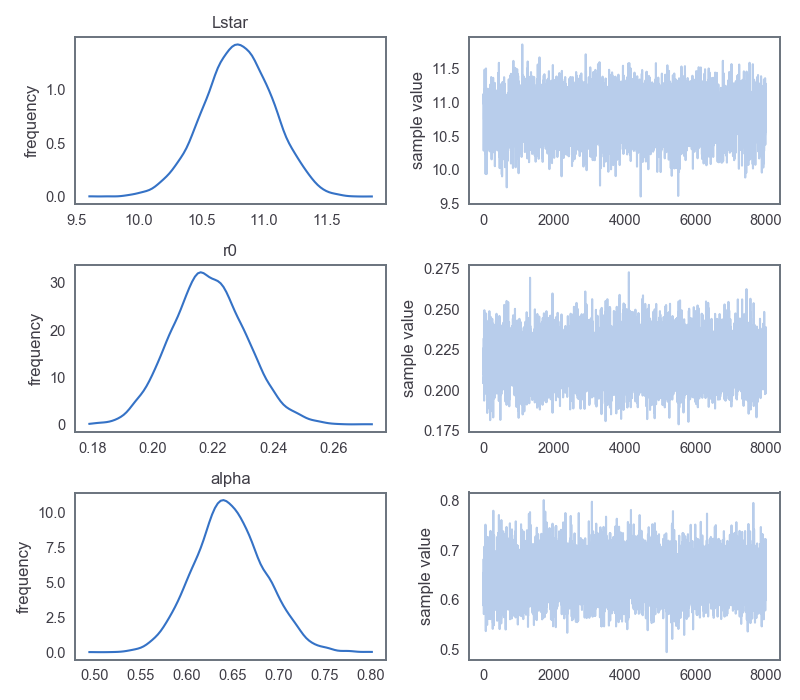

In [60]:
fit.plot(['Lstar','r0','alpha',
         # 'rise','decay', 'peak'
         ]);
plt.tight_layout()

<IPython.core.display.Javascript object>


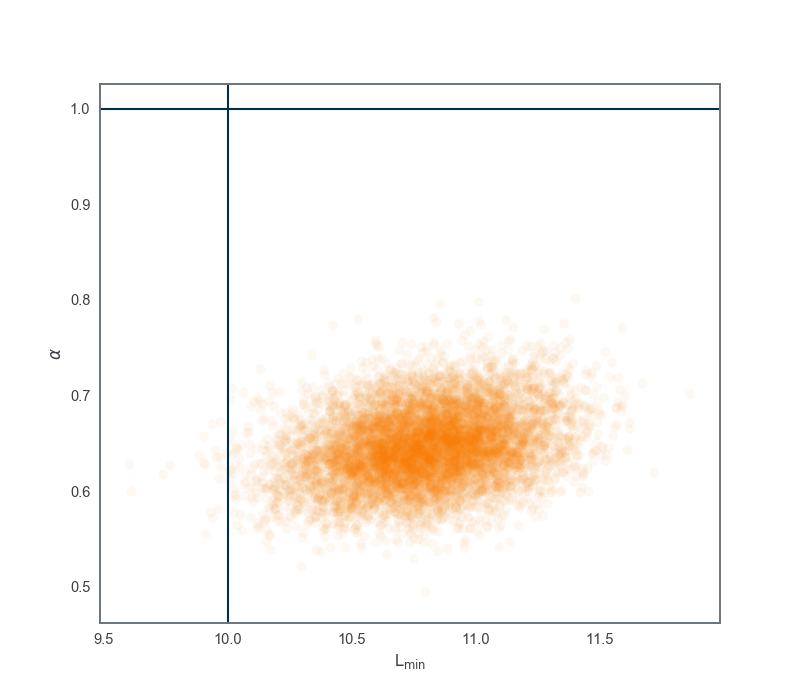

Text(0,0.5,'$\\alpha$')

In [61]:
fig, ax = plt.subplots()


ax.scatter(fit.extract()['Lstar'],
           fit.extract()['alpha'],
           c=orange,
           alpha=0.05,
           edgecolor='none',
           s=50)

ax.axhline(alpha_true,color=dark)
ax.axvline(Lmin_true,color=dark)

ax.set_xlabel(r'L$_{\mathrm{min}}$')
ax.set_ylabel(r'$\alpha$')

<IPython.core.display.Javascript object>


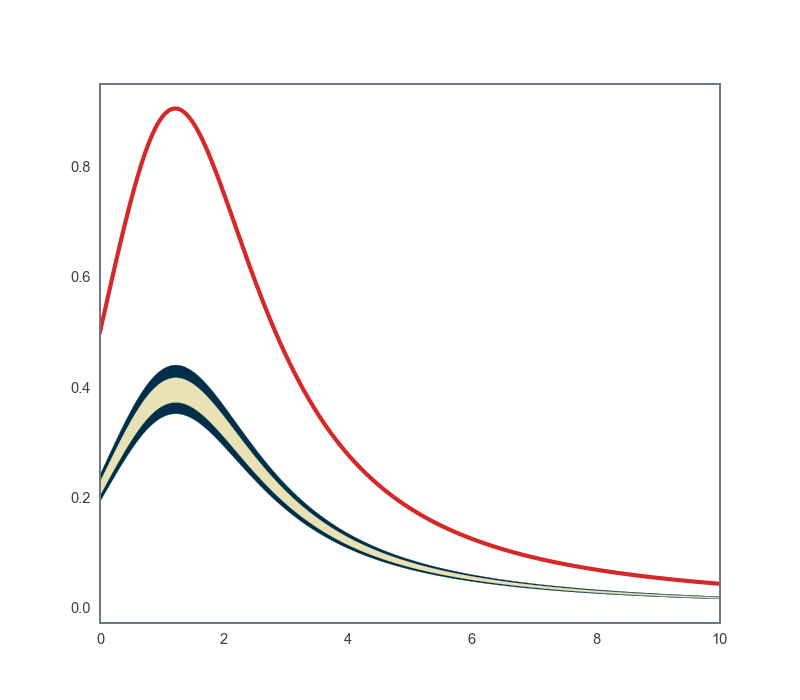

(0, 10)

In [62]:
fig, ax = plt.subplots()

dndzmodel = fit.extract()['dNdV_model']

up = np.percentile(dndzmodel,50 +95./2. ,axis=0)
down = np.percentile(dndzmodel,50 -95./2. ,axis=0)
ax.fill_between(data['zmodel'], down, up, color=dark)

up = np.percentile(dndzmodel,50 +68/2 ,axis=0)
down = np.percentile(dndzmodel,50 -68/2 ,axis=0)
ax.fill_between(data['zmodel'], down, up, color=light)



ax.plot(data['zmodel'], dNdV(data['zmodel'],r0_true,rise_true, decay_true, peak_true),color=red,lw=3)

ax.set_xlim(0,10)

<IPython.core.display.Javascript object>


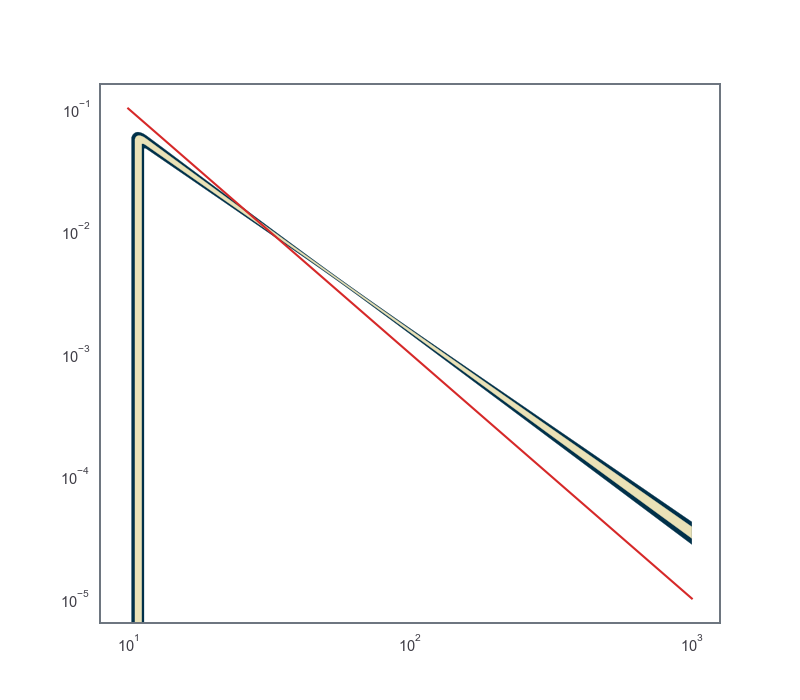

In [63]:
fig, ax = plt.subplots()

phimodel = fit.extract()['phi_model']

up = np.percentile(phimodel,50 +95./2. ,axis=0)
down = np.percentile(phimodel,50 -95./2. ,axis=0)
ax.fill_between(data['Lmodel'], down, up,color=dark)

up = np.percentile(phimodel,50 +68/2 ,axis=0)
down = np.percentile(phimodel,50 -68/2 ,axis=0)
ax.fill_between(data['Lmodel'], down, up,color=light)
ax.loglog(data['Lmodel'], phi(data['Lmodel'],alpha_true,Lmin_true),color=red)

